In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/predict-demand/train.csv
/kaggle/input/predict-demand/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6

In [4]:
train = pd.read_csv('/kaggle/input/predict-demand/train.csv')
test = pd.read_csv('/kaggle/input/predict-demand/test.csv')

In [5]:
# All values after row 6479 are NaN.
train  = train.drop(train.index[6480:])
train.tail()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
6475,6475.0,31/12/17,Athens,37.96245,23.68708,665871.0,shop_3,orange-power,plastic,1.5lt,1.02,33201.0
6476,6476.0,31/12/17,Larisa,39.63689,22.41761,144302.0,shop_5,orange-power,can,330ml,0.47,46971.0
6477,6477.0,31/12/17,Patra,38.24444,21.73444,168501.0,shop_6,adult-cola,glass,500ml,1.02,47708.0
6478,6478.0,31/12/17,Thessaloniki,40.64361,22.93086,353001.0,shop_4,gazoza,plastic,1.5lt,1.34,27115.0
6479,6479.0,31/12/17,Thessaloniki,40.64361,22.93086,353001.0,shop_4,adult-cola,glass,500ml,1.16,30413.0


In [6]:
# See the types of sodas we have. We will only be working with Gazoza.
pd.DataFrame(train.groupby(['brand', 'container'], axis =0, as_index=True).count()['id'])

id
brand        container     
adult-cola   can        430
             glass      432
             plastic    432
gazoza       can        431
             glass      429
             plastic    431
kinder-cola  can        431
             glass      431
             plastic    432
lemon-boost  can        431
             glass      432
             plastic    431
orange-power can        430
             glass      430
             plastic    431

## Clean Data

In [7]:
gazoza_train = train[train['brand'] == 'gazoza'].reset_index(drop=True)

# Fill in the missing contiainer types
gazoza_train.at[340, 'container'] = 'can'
gazoza_train.at[798, 'container'] = 'glass'
gazoza_train.at[984, 'container'] = 'glass'
gazoza_train.at[1214, 'container'] = 'plastic'
gazoza_train.at[1229, 'container'] = 'glass'
# Fill in the missing capacity types
gazoza_train.at[368, 'capacity'] = '1.5lt'
gazoza_train.at[648, 'capacity'] = '500ml'
gazoza_train.at[962, 'capacity'] = '500ml'
# Choose features
# gazoza_train.drop(['id','shop','long','brand','container'], axis=1, inplace=True)
gazoza_train['date'] = pd.to_datetime(gazoza_train['date'])
# Remove the sufix of the values of the capacity column, Change into numerics
gazoza_train['capacity'] = gazoza_train['capacity'].map(lambda x: str(x)[:-2])
gazoza_train['capacity'] = pd.to_numeric(gazoza_train['capacity'])

#----------------------

gazoza_test = test[test['brand'] == 'gazoza'].reset_index(drop=True)
# Fill in the missing capacity types
gazoza_test.at[208, 'capacity'] = '330ml'
gazoza_test.at[209, 'capacity'] = '500ml'
# Choose features
# gazoza_test.drop(['id','shop','long','brand','container'], axis=1, inplace=True)
gazoza_test['date'] = pd.to_datetime(gazoza_test['date'])
# Remove the sufix of the values of the capacity column, Change into numerics
gazoza_test['capacity'] = gazoza_test['capacity'].map(lambda x: str(x)[:-2])
gazoza_test['capacity'] = pd.to_numeric(gazoza_test['capacity'])

# -----------------------
gazoza_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         216 non-null    int64         
 1   date       216 non-null    datetime64[ns]
 2   city       216 non-null    object        
 3   lat        213 non-null    float64       
 4   long       211 non-null    float64       
 5   pop        216 non-null    int64         
 6   shop       216 non-null    object        
 7   brand      216 non-null    object        
 8   container  216 non-null    object        
 9   capacity   216 non-null    float64       
 10  price      216 non-null    float64       
 11  quantity   216 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 20.4+ KB


In [8]:
# Fill in the missing values for lat column of training set
gazoza_train['lat'] = gazoza_train.apply(lambda row: 37.97945 if (row['shop'] == 'shop_1') else row['lat'],axis=1)
gazoza_train['lat'] = gazoza_train.apply(lambda row: 35.32787 if (row['shop'] == 'shop_2') else row['lat'],axis=1)
gazoza_train['lat'] = gazoza_train.apply(lambda row: 37.96245 if (row['shop'] == 'shop_3') else row['lat'],axis=1)
gazoza_train['lat'] = gazoza_train.apply(lambda row: 39.63689 if (row['shop'] == 'shop_5') else row['lat'],axis=1)
gazoza_train['lat'] = gazoza_train.apply(lambda row: 38.24444 if (row['shop'] == 'shop_6') else row['lat'],axis=1)

# Fill in the missing values for long column of training set
gazoza_train['long'] = gazoza_train.apply(lambda row: 23.68708 if (row['shop'] == 'shop_3') else row['long'],axis=1)
gazoza_train['long'] = gazoza_train.apply(lambda row: 22.93086 if (row['shop'] == 'shop_4') else row['long'],axis=1)
gazoza_train['long'] = gazoza_train.apply(lambda row: 21.73444 if (row['shop'] == 'shop_6') else row['long'],axis=1)

# Fill in the missing values for lat column of testing set
gazoza_test['lat'] = gazoza_test.apply(lambda row: 37.96245 if (row['shop'] == 'shop_3') else row['lat'],axis=1)
gazoza_test['lat'] = gazoza_test.apply(lambda row: 39.63689 if (row['shop'] == 'shop_5') else row['lat'],axis=1)


# Fill in the missing values for long column of testing set
gazoza_test['long'] = gazoza_test.apply(lambda row: 23.68708 if (row['shop'] == 'shop_3') else row['long'],axis=1)
gazoza_test['long'] = gazoza_test.apply(lambda row: 21.73444 if (row['shop'] == 'shop_6') else row['long'],axis=1)
gazoza_test['long'] = gazoza_test.apply(lambda row: 25.14341 if (row['shop'] == 'shop_2') else row['long'],axis=1)
gazoza_test['long'] = gazoza_test.apply(lambda row: 23.71622 if (row['shop'] == 'shop_1') else row['long'],axis=1)
gazoza_test['long'] = gazoza_test.apply(lambda row: 22.41761 if (row['shop'] == 'shop_5') else row['long'],axis=1)

In [9]:
gazoza_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         1296 non-null   float64       
 1   date       1296 non-null   datetime64[ns]
 2   city       1296 non-null   object        
 3   lat        1296 non-null   float64       
 4   long       1296 non-null   float64       
 5   pop        1296 non-null   float64       
 6   shop       1296 non-null   object        
 7   brand      1296 non-null   object        
 8   container  1296 non-null   object        
 9   capacity   1296 non-null   float64       
 10  price      1296 non-null   float64       
 11  quantity   1296 non-null   float64       
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 121.6+ KB


In [10]:
gazoza_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         216 non-null    int64         
 1   date       216 non-null    datetime64[ns]
 2   city       216 non-null    object        
 3   lat        216 non-null    float64       
 4   long       216 non-null    float64       
 5   pop        216 non-null    int64         
 6   shop       216 non-null    object        
 7   brand      216 non-null    object        
 8   container  216 non-null    object        
 9   capacity   216 non-null    float64       
 10  price      216 non-null    float64       
 11  quantity   216 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(4)
memory usage: 20.4+ KB


In [11]:
# Convert the leters to ml

to_scale_index = gazoza_train[gazoza_train['capacity'] == 1.5]['capacity'].index
for x in to_scale_index:
    gazoza_train.at[x, 'capacity'] = gazoza_train.at[x, 'capacity'] * 1000
    
to_scale_index = gazoza_test[gazoza_test['capacity'] == 1.5]['capacity'].index
for x in to_scale_index:
    gazoza_test.at[x, 'capacity'] = gazoza_test.at[x, 'capacity'] * 1000

In [12]:
gazoza_test.head()

,id,date,city,lat,long,pop,shop,brand,container,capacity,price,quantity
0,6485,2018-01-31,Athens,37.97945,23.71622,664046,shop_1,gazoza,glass,500.0,0.77,24297
1,6486,2018-01-31,Athens,37.97945,23.71622,664046,shop_1,gazoza,plastic,1500.0,1.22,21295
2,6487,2018-01-31,Athens,37.97945,23.71622,664046,shop_1,gazoza,can,330.0,0.28,38107
3,6496,2018-01-31,Irakleion,35.32787,25.14341,137154,shop_2,gazoza,plastic,1500.0,1.27,26491
4,6508,2018-01-31,Patra,38.24444,21.73444,168034,shop_6,gazoza,plastic,1500.0,1.43,25790


In [13]:
gazoza_test['city'].unique()

array(['Athens', 'Irakleion', 'Patra', 'Thessaloniki', 'Larisa'],
      dtype=object)

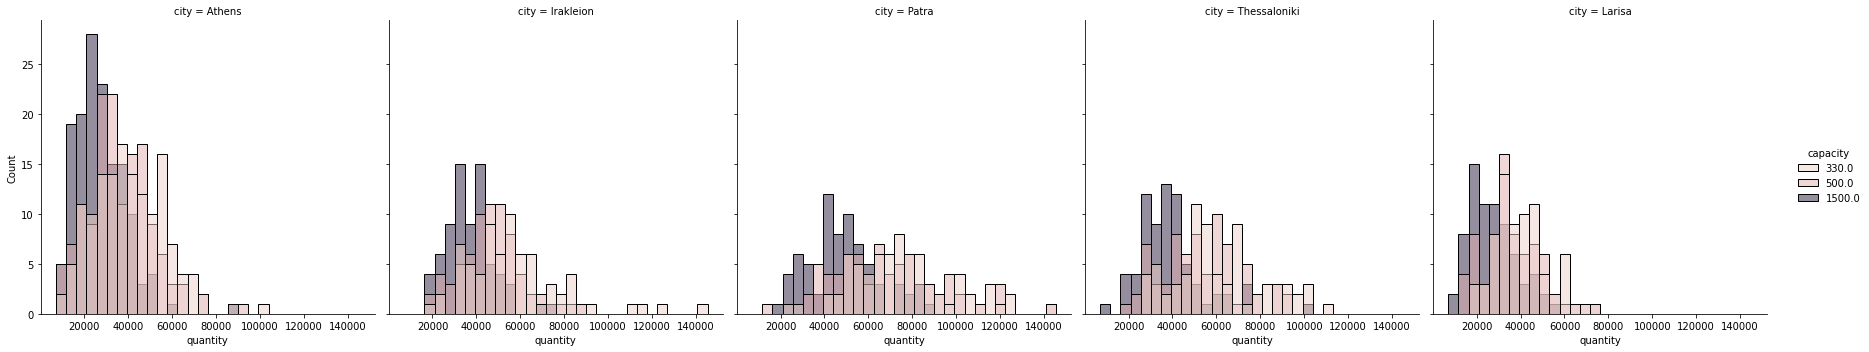

In [14]:
sns.displot(gazoza_train, x = 'quantity', col = 'city', hue = 'capacity')

In [15]:
# Diaggregate the data by city and container type
disaggreg_data = []

for city in gazoza_train['city'].unique():
    for container in gazoza_train['container'].unique():
        disaggreg_data.append(gazoza_train[(gazoza_train['city'] == city) & (gazoza_train['container'] == container)])
        print(city,container)

Athens glass
Athens plastic
Athens can
Irakleion glass
Irakleion plastic
Irakleion can
Patra glass
Patra plastic
Patra can
Thessaloniki glass
Thessaloniki plastic
Thessaloniki can
Larisa glass
Larisa plastic
Larisa can


In [16]:
df_AG = pd.DataFrame(disaggreg_data[0])
df_AP = pd.DataFrame(disaggreg_data[1])
df_AC = pd.DataFrame(disaggreg_data[2])
df_IG = pd.DataFrame(disaggreg_data[3])
df_IP = pd.DataFrame(disaggreg_data[4])
df_IC = pd.DataFrame(disaggreg_data[5])
df_PG = pd.DataFrame(disaggreg_data[6])
df_PP = pd.DataFrame(disaggreg_data[7])
df_PC = pd.DataFrame(disaggreg_data[8])
df_TG = pd.DataFrame(disaggreg_data[9])
df_TP = pd.DataFrame(disaggreg_data[10])
df_TC = pd.DataFrame(disaggreg_data[11])
df_LG = pd.DataFrame(disaggreg_data[12])
df_LP = pd.DataFrame(disaggreg_data[13])
df_LC = pd.DataFrame(disaggreg_data[14])

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA

In [18]:
# this method comples a time series analysis and returns the forecast for the next 12 months
def tsa_method(gazoza_train):
    qty = pd.DataFrame(gazoza_train.groupby(['date'], axis =0, as_index=True).sum()['quantity'])
    qty_test = pd.DataFrame(gazoza_test.groupby(['date'], axis =0, as_index=True).sum()['quantity'])
    print(qty.shape)
    qty_log = np.log(qty)
    desomposition = seasonal_decompose(qty_log)
    trend = desomposition.trend
    seasonal = desomposition.seasonal
    resedual = desomposition.resid
    decomposedLogData = resedual
    decomposedLogData.dropna(inplace = True)
    dataLogDiffShifting = qty_log - qty_log.shift()
    dataLogDiffShifting.dropna(inplace=True)
    lag_acf = acf(dataLogDiffShifting, nlags = 4)
    lag_pacf = pacf(dataLogDiffShifting, nlags = 4, method = 'ols') # ordinary least square
    model = ARIMA(qty_log, order = (2,1,2)) #P, d, Q values
    results_ARIMA = model.fit(disp = -1)
    #predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy = True)
    forecast_18 = pd.Series(results_ARIMA.forecast(steps=12)[0])
    forecast_18.index = qty_test.index
    
    return forecast_18
    

In [19]:
NN_pred = [27995.53125, 23516.5625, 43323.83203125, 29774.40234375, 33537.34765625, 70139.9453125, 43992.3203125, 52559.10546875, 28519.216796875, 41201.68359375, 37230.76171875, 28008.6328125, 15068.306640625, 53544.8515625, 27877.029296875, 55124.234375, 46199.5234375, 37970.35546875, 20397.423828125, 17169.49609375, 24014.318359375, 30734.091796875, 19227.01953125, 35711.67578125, 43398.37109375, 24988.18359375, 49291.14453125, 33905.75390625, 21092.140625, 18523.40625, 8996.20703125, 32146.455078125, 13686.7841796875, 14233.4130859375, 27304.142578125, 46164.00390625, 31509.890625, 26958.54296875, 38854.87109375, 38880.48828125, 35190.87109375, 49890.19140625, 71913.0625, 40483.1875, 34886.7421875, 19460.2265625, 37590.765625, 31629.5234375, 38371.40234375, 34561.57421875, 55011.75, 58391.1875, 23737.64453125, 45129.44140625, 25710.375, 33765.53515625, 34778.96875, 31293.46484375, 47564.203125, 37007.83203125, 33198.61328125, 31615.2265625, 30672.3203125, 16498.169921875, 25355.603515625, 38380.02734375, 19921.14453125, 15839.169921875, 52092.11328125, 52734.98046875, 66335.6875, 38484.32421875, 33439.15234375, 21001.66796875, 42554.59765625, 35852.05859375, 50307.07421875, 50665.0, 69231.234375, 42383.16015625, 26663.25, 53392.8671875, 28573.515625, 34009.9453125, 39956.50390625, 26632.994140625, 37432.921875, 41723.14453125, 49404.46875, 45379.0546875, 26688.580078125, 37427.03125, 37474.4921875, 24938.96484375, 48030.3046875, 43909.546875, 29060.2109375, 67551.9375, 50301.796875, 23725.052734375, 13720.724609375, 33999.34375, 28512.76953125, 10637.6240234375, 39149.33203125, 25444.76171875, 30374.298828125, 35924.77734375, 31564.185546875, 29570.2890625, 40910.09375, 26785.978515625, 53981.1875, 52303.34375, 35203.890625, 69333.734375, 42392.890625, 37152.0234375, 58010.87890625, 32404.88671875, 29477.134765625, 44852.078125, 26087.58203125, 41751.3203125, 49078.78515625, 20083.494140625, 32528.818359375, 43357.875, 44197.8046875, 33356.62890625, 45851.48828125, 71055.59375, 43619.21484375, 42871.9375, 30516.349609375, 32907.0078125, 41599.7109375, 21804.482421875, 21607.615234375, 57112.26953125, 40662.93359375, 34989.27734375, 54343.9765625, 52764.5859375, 31167.564453125, 39070.9609375, 47230.59375, 37018.05078125, 38778.203125, 28512.91015625, 27252.984375, 42987.33203125, 26270.578125, 24253.88671875, 40682.4296875, 41081.109375, 51537.83984375, 25260.09765625, 64921.359375, 13649.220703125, 50031.4375, 19499.998046875, 27483.662109375, 19638.134765625, 39703.21875, 41357.453125, 24828.607421875, 55624.38671875, 56818.8671875, 44787.83984375, 75056.171875, 46479.01171875, 40996.97265625, 53417.18359375, 29909.45703125, 21538.673828125, 41609.44140625, 35022.06640625, 26955.34375, 44190.3828125, 30243.65625, 23796.41796875, 34811.61328125, 43152.23046875, 51311.85546875, 53467.75, 41293.0859375, 70035.671875, 39494.1171875, 29174.099609375, 58109.79296875, 32986.46875, 27690.654296875, 40554.1328125, 28288.490234375, 37389.99609375, 14594.43359375, 18129.9140625, 35436.28515625, 26497.876953125, 46253.0234375, 39117.265625, 56855.5703125, 55177.7265625, 44436.01953125, 71817.46875, 46895.90234375, 36585.85546875, 58718.1640625, 37862.078125, 16612.62890625, 41212.01171875, 34686.59375, 26125.1171875, 46643.03125, 49484.62890625]
NN_comp = pd.Series(NN_pred, index = gazoza_test['date'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warning

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:701: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:702: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: Fut

Text(0, 0.5, 'Quantity Sold')

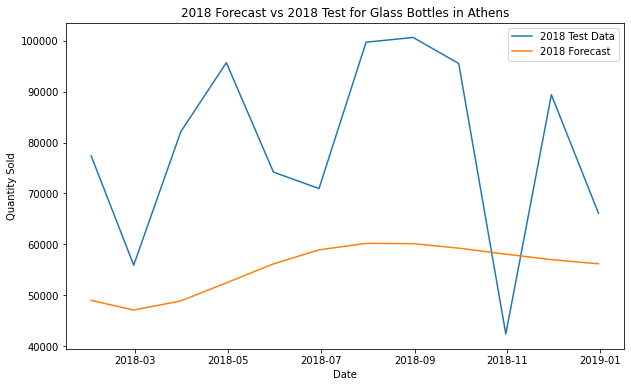

In [20]:
df_AG_test = gazoza_test[(gazoza_test['city'] == 'Athens') & (gazoza_train['container'] == 'glass')]
qty_AG_test = pd.DataFrame(df_AG_test.groupby(['date'], axis =0, as_index=True).sum()['quantity'])

plt.plot(qty_AG_test, label = "2018 Test Data")
plt.plot(np.exp(tsa_method(df_AG)), label = "2018 Forecast")
# plt.plot(np.exp(low_bound), linestyle = '--', color ='gray', label = '95% Confidence Interval')
# plt.plot(np.exp(high_bound), linestyle = '--', color ='gray')
plt.legend(loc='best')
plt.title("2018 Forecast vs 2018 Test for Glass Bottles in Athens")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")

In [21]:
aggregated_tsa_forecast = np.exp(tsa_method(df_AG)) + np.exp(tsa_method(df_AP)) + np.exp(tsa_method(df_AC)) + np.exp(tsa_method(df_IG)) + np.exp(tsa_method(df_IP)) + np.exp(tsa_method(df_IC)) + np.exp(tsa_method(df_PG)) + np.exp(tsa_method(df_PP)) +np.exp(tsa_method(df_PC)) + np.exp(tsa_method(df_TG)) +np.exp(tsa_method(df_TP)) + np.exp(tsa_method(df_TC)) + np.exp(tsa_method(df_LG)) +np.exp(tsa_method(df_LP)) + np.exp(tsa_method(df_LC))
#aggregated_tsa_forecast = tsa_method(df_AG) + tsa_method(df_AP) + tsa_method(df_AC) + tsa_method(df_IG) + tsa_method(df_IP) + tsa_method(df_IC) + tsa_method(df_PG) + tsa_method(df_PP) + tsa_method(df_PC) + tsa_method(df_TG) + tsa_method(df_TP) + tsa_method(df_TC) + tsa_method(df_LG) + tsa_method(df_LP) + tsa_method(df_LC)


(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                 

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECA

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECA

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of stat

(72, 1)
(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECA

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of stat

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of stat

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of stat

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of stat

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECA

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of stat

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of stat

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of stat

(72, 1)


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [22]:
qty_test = pd.DataFrame(gazoza_test.groupby(['date'], axis =0, as_index=True).sum()['quantity'])

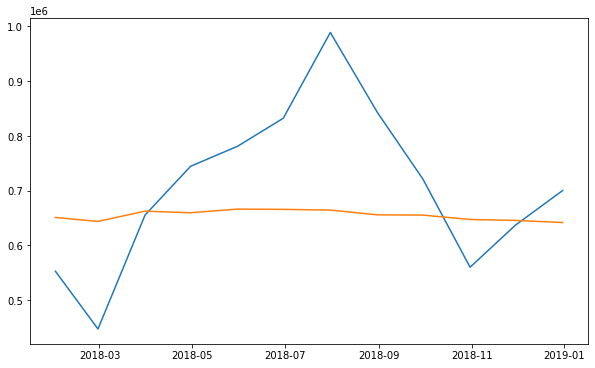

In [23]:
plt.plot(qty_test, label = "2018 Test Data")
plt.plot(aggregated_tsa_forecast, label = "2018 Forecast")